In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
import skimage
import cv2
from scipy.fftpack import dct, idct
from skimage.metrics import normalized_root_mse as rmse
from skimage.metrics import mean_squared_error as mse
import copy
import matplotlib.animation as animation

#### **1-D DCT**

In [2]:
# Function to Compute 1D DCT

def DCT_1D(x):

    N = len(x)

    DCT_MAT = np.array([ [ 2 * math.cos((2*n+1)*math.pi*k/(2*N)) for n in range(N) ] for k in range(N) ])

    X = np.matmul(DCT_MAT,x)

    return X

#### **2-D DCT**

In [3]:
# Function to Compute 2D DCT

def DCT_2D(I):

    row_DCT = DCT_1D(np.transpose(np.array(I)))                                 # Row wise DCT
    DCT_image = DCT_1D(np.transpose(row_DCT))                                   # Column wise DCT

    return DCT_image

#### **2-D Block DCT**

In [4]:
# FUnction to create patches

def create_patches(I, patch_size):
    M,N = I.shape

    patches = []

    for i in np.arange(0,M,patch_size[0]):
        for j in np.arange(0,N,patch_size[1]):
            patches.append(I[i:i+patch_size[0],j:j+patch_size[1]])
        patches.append(I[i:i+patch_size[0],j:j+patch_size[1]])

    return patches

In [5]:
# Function to stitch patches

def stitch_patches(patches, patch_size, image_size):

    no_horizontal_patches = int(image_size[1]/patch_size[1])

    row_patches = [np.hstack(patches[i:i+no_horizontal_patches]) for i in range(0,len(patches),no_horizontal_patches+1) ]

    reconstructed_image = np.vstack(row_patches)

    return reconstructed_image

In [6]:
# Function to Compute Block2D DCT

def BLOCK_DCT_2D(I, patch_size):

    image_patches = create_patches(I, patch_size = patch_size)
    DCT_patches = []

    for patch in image_patches:

        row_DCT = DCT_1D(np.transpose(np.array(patch)))
        row_column_DCT = DCT_1D(np.transpose(row_DCT))

        DCT_patches.append(row_column_DCT)

    DCT_image = stitch_patches(DCT_patches, patch_size, image_size=I.shape)

    return DCT_image

#### **2-D IDCT**

In [110]:
# Function to Compute 1D IDCT

def IDCT_1D(x):

    N = len(x)

    DCT_MAT = np.array([ [ 1 if n==0 else 2 * math.cos((2*n+1)*math.pi*k/(2*N)) for n in range(N) ] for k in range(N) ]) # IDCT Matrix

    X = np.matmul(DCT_MAT,x)

    return X

In [118]:
# Function to reconstruct image retaining only top m DCT components

def reconstruct_image(DCT_image, m):

    thresh = np.sort((np.abs(DCT_image.copy())).ravel())[::-1][int(m)-1]
    DCT_image[np.abs(DCT_image)<=thresh] = 0

    return IDCT_1D(IDCT_1D(DCT_image.T).T)


In [9]:
# Function to reconstruct image retaining only top m Block DCT components

def reconstruct_image_block(DCT_image, patch_size, m):

    dct_patches = create_patches(DCT_image.copy(), patch_size = patch_size)

    output_patches = []

    for patch in dct_patches:
        patch_copy = patch.copy()
        thresh = np.sort((np.abs(patch_copy)).ravel())[::-1][int(m)-1]
        patch[np.abs(patch)<=thresh] = 0

        output_patches.append(IDCT_1D(IDCT(patch.T).T))

    output_image = stitch_patches(output_patches, patch_size, image_size=DCT_image.shape)

    return output_image

### **Problem 4**

#### **Cosine Image**

In [115]:
# Signal

k1, k2, M, N = 10, 8, 48, 32
m, n = np.linspace(0,M-1,num = M), np.linspace(0,N-1,num = N)

cos_k1, cos_k2 = np.meshgrid(np.cos(2*math.pi*k2*n/N),np.cos(2*math.pi*k1*m/M))

cosine = cos_k1*cos_k2

# FSCS
# cosine -= np.min(cosine)
# cosine *= 255/np.max(cosine)

(-0.5, 31.5, 47.5, -0.5)

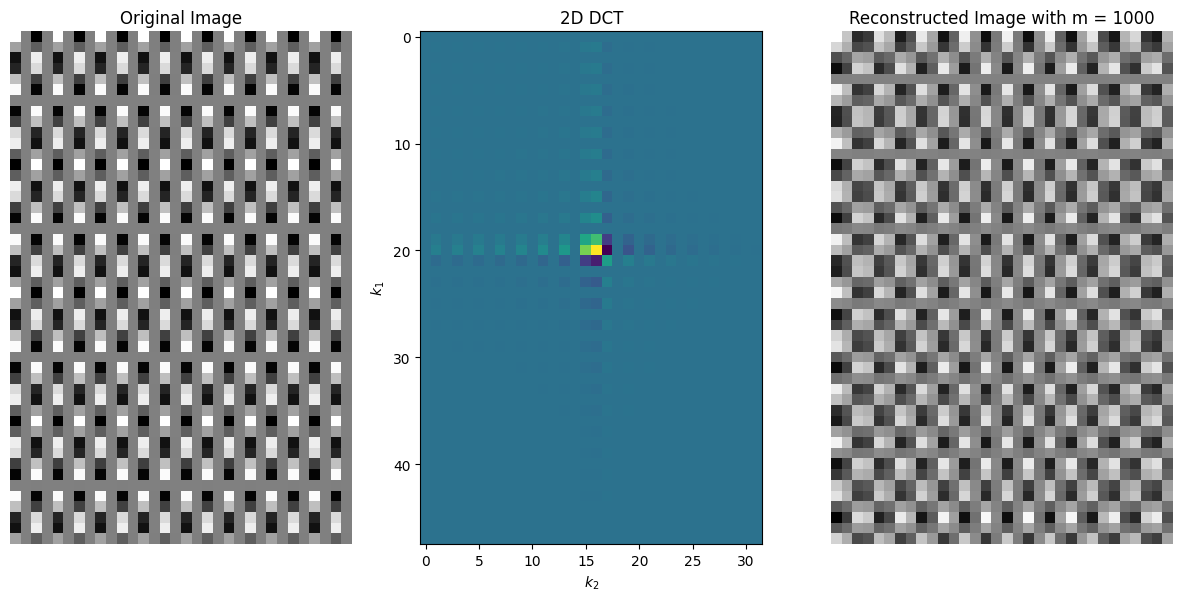

In [120]:
dct_cosine = DCT_2D(cosine)

plt.figure(figsize = (15,10))

plt.subplot(131)
plt.imshow(cosine,cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(dct_cosine)
plt.title('2D DCT')
plt.xlabel('$k_2$')
plt.ylabel('$k_1$')

plt.subplot(133)
plt.imshow(reconstruct_image(dct_cosine, 1000), cmap = 'gray')
plt.title(f'Reconstructed Image with m = {1000}')
plt.axis('off')

In [104]:
reconstruction_errors_cosine = []

dct_cosine = DCT_2D(cosine)
normalized_cosine = cosine.copy() - np.min(cosine)
normalized_cosine /= np.max(normalized_cosine)

for m in np.linspace(1, np.prod(cosine.shape), 100):

    reconstructed_image = reconstruct_image(dct_cosine.copy(), m)
    reconstructed_image -= np.min(reconstructed_image)
    reconstructed_image /= np.max(reconstructed_image)

    reconstruction_errors_cosine.append(mse(normalized_cosine, reconstructed_image))

<ipython-input-104-2115ed2f5546>:11: RuntimeWarning: invalid value encountered in divide
  reconstructed_image /= np.max(reconstructed_image)


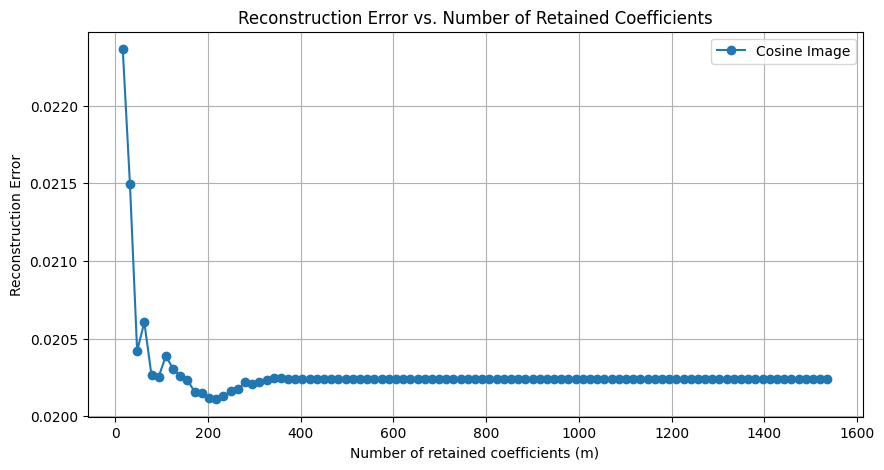

In [105]:
# Plot reconstruction errors as a function of m
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(1, np.prod(cosine.shape), 100), reconstruction_errors_cosine,'o-', label='Cosine Image')
plt.xlabel('Number of retained coefficients (m)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs. Number of Retained Coefficients')
plt.legend()
plt.grid(True)
plt.show()

#### **Cameraman Image**

In [15]:
# Image
cameraman = skimage.io.imread('cameraman.tif').astype(float)

# cameraman -= np.min(cameraman)
# cameraman *= 255/np.max(cameraman)

(-0.5, 255.5, 255.5, -0.5)

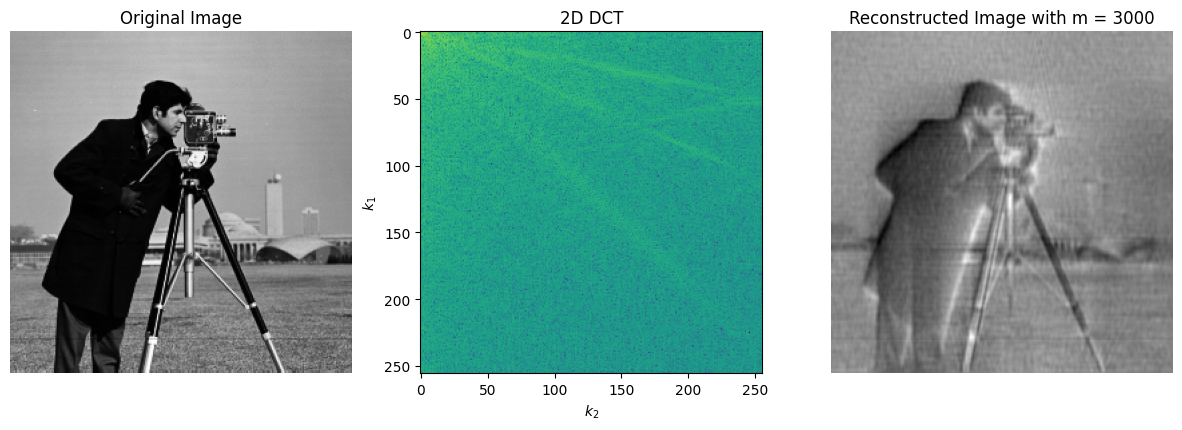

In [117]:
dct_cameraman = DCT_2D(cameraman)

plt.figure(figsize = (15,10))
plt.subplot(131)
plt.imshow(cameraman,cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(np.log(np.abs(dct_cameraman)))
plt.title('2D DCT')
plt.xlabel('$k_2$')
plt.ylabel('$k_1$')

plt.subplot(133)
plt.imshow(reconstruct_image(dct_cameraman,3000),cmap='gray')
plt.title(f'Reconstructed Image with m = {3000}')
plt.axis('off')

In [17]:
reconstruction_errors_cameraman = []

dct_cameraman = DCT_2D(cameraman)
normalized_cameraman = cameraman - np.min(cameraman)
normalized_cameraman /= np.max(normalized_cameraman)

for m in np.linspace(1000, np.prod(cameraman.shape), 100):

    reconstructed_image = reconstruct_image(dct_cameraman.copy(), m)
    reconstructed_image -= np.min(reconstructed_image)
    reconstructed_image /= np.max(reconstructed_image)
    # print(np.max(reconstructed_image), np.min(reconstructed_image))
    # print(reconstructed_image)

    reconstruction_errors_cameraman.append(mse(normalized_cameraman, reconstructed_image))

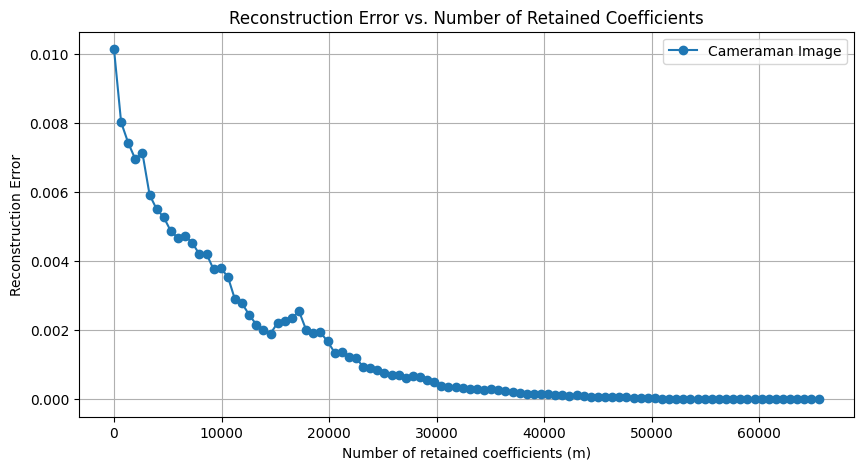

In [18]:
# Plot reconstruction errors as a function of m
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(1, np.prod(cameraman.shape),100), reconstruction_errors_cameraman,'o-', label='Cameraman Image')
plt.xlabel('Number of retained coefficients (m)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs. Number of Retained Coefficients')
plt.legend()
plt.grid(True)
plt.show()

#### **Peppers Image - 2D Block DCT**

In [19]:
peppers = skimage.color.rgb2gray(skimage.io.imread('pepper.png'))

In [20]:
block_dct = BLOCK_DCT_2D(peppers ,patch_size = (8,8))

In [21]:
output_peppers = reconstruct_image_block(block_dct, patch_size = (8,8), m=2)

(-0.5, 511.5, 511.5, -0.5)

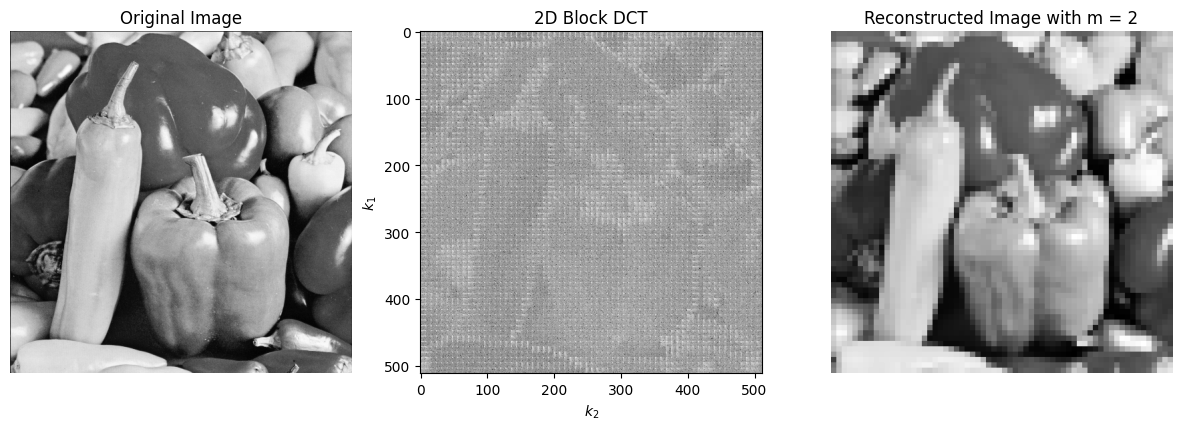

In [80]:
plt.figure(figsize = (15,10))
plt.subplot(131)
plt.title('Original Image')
plt.axis('off')
plt.imshow(peppers,cmap='gray')

plt.subplot(132)
plt.imshow(np.log(np.abs(block_dct)), cmap='gray')
plt.title('2D Block DCT')
plt.xlabel('$k_2$')
plt.ylabel('$k_1$')

plt.subplot(133)
plt.imshow(output_peppers,cmap='gray')
plt.title(f'Reconstructed Image with m = {2}')
plt.axis('off')

In [25]:
reconstruction_errors_peppers = []

block_dct_peppers = BLOCK_DCT_2D(peppers ,patch_size = (8,8))

normalized_peppers = peppers - np.min(peppers)
normalized_peppers /= np.max(normalized_peppers)

for m in np.linspace(2,64, 64):

    reconstructed_image = reconstruct_image_block(block_dct_peppers.copy(), patch_size = (8,8), m=m)
    reconstructed_image -= np.min(reconstructed_image)
    reconstructed_image /= np.max(reconstructed_image)

    reconstruction_errors_peppers.append(mse(normalized_peppers, reconstructed_image))

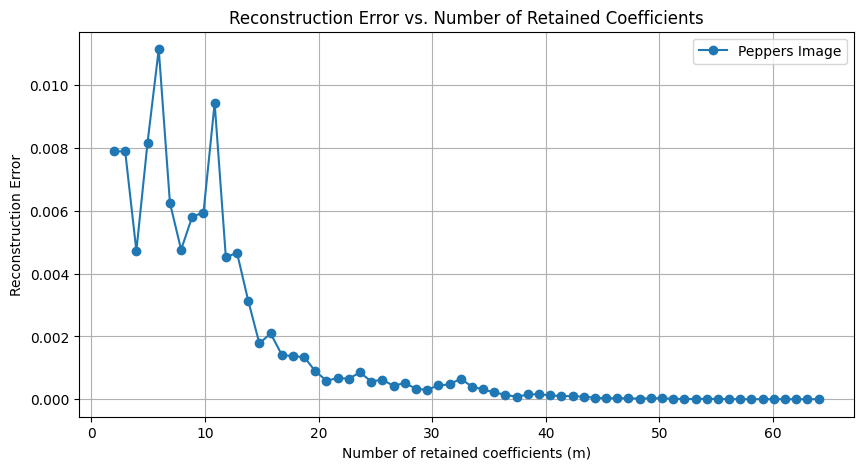

In [27]:
# Plot reconstruction errors as a function of m
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(2,64,64), reconstruction_errors_peppers,'o-', label='Peppers Image')
plt.xlabel('Number of retained coefficients (m)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs. Number of Retained Coefficients')
plt.legend()
plt.grid(True)
plt.show()